<a href="https://colab.research.google.com/github/shriprasad15/MaskRCNN/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original Image Size: (1537, 2049)
Resized Image Size: (640, 640)
Original Image Size: (1537, 2049)
Resized Image Size: (640, 640)
Original Image Size: (1537, 2049)
Resized Image Size: (640, 640)


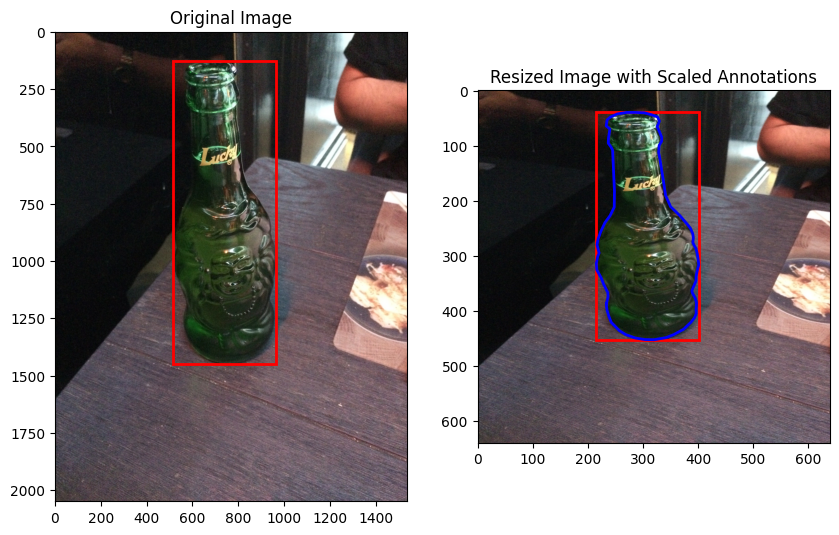

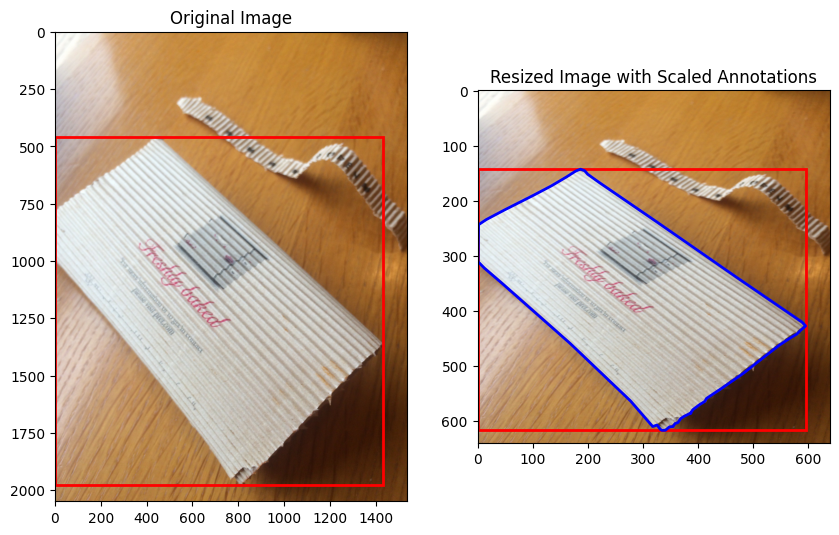

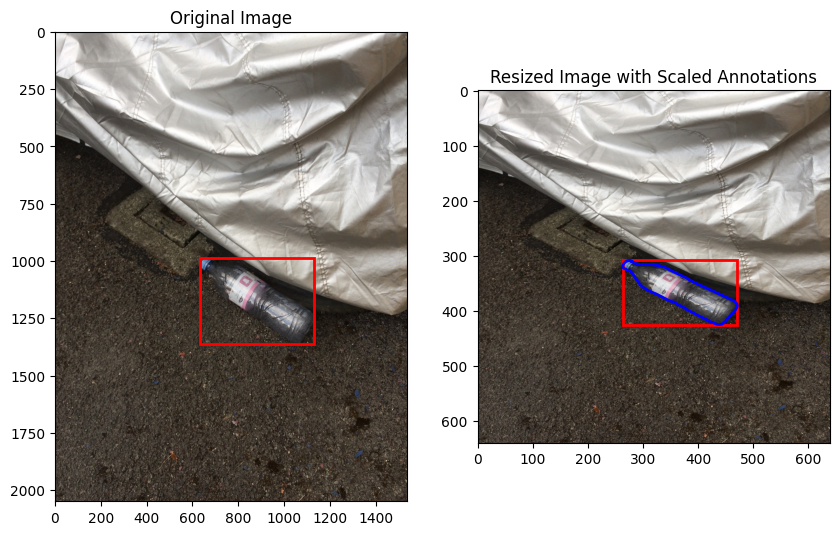

In [ ]:
import json
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the annotations JSON file
with open('annotations.json') as f:
    annotations = json.load(f)

# Define a function to scale bounding boxes
def scale_bounding_box(bbox, original_size, new_size):
    original_width, original_height = original_size
    new_width, new_height = new_size

    scale_x = new_width / original_width
    scale_y = new_height / original_height

    x_min, y_min, width, height = bbox
    new_x_min = x_min * scale_x
    new_y_min = y_min * scale_y
    new_width = width * scale_x
    new_height = height * scale_y

    return [new_x_min, new_y_min, new_width, new_height]

# Define a function to scale segmentation masks
def scale_segmentation(segmentation, original_size, new_size):
    original_width, original_height = original_size
    new_width, new_height = new_size

    scale_x = new_width / original_width
    scale_y = new_height / original_height

    scaled_segmentation = []
    for i in range(0, len(segmentation), 2):
        x = segmentation[i] * scale_x
        y = segmentation[i+1] * scale_y
        scaled_segmentation.extend([x, y])

    return scaled_segmentation

# Select a few images to test
test_images = annotations['images'][:3]  # Select the first three images

for image_info in test_images:
    # Load image
    response = requests.get(image_info['flickr_url'])
    img = Image.open(BytesIO(response.content))

    original_size = img.size
    print(f"Original Image Size: {original_size}")

    # Resize image
    new_size = (640, 640)  # Example new size
    img_resized = img.resize(new_size, Image.LANCZOS)
    print(f"Resized Image Size: {new_size}")

    # Display original image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")

    # Find corresponding annotation
    annotation_id = image_info['id']

    for ann in annotations.get('annotations', []):
        if ann['image_id'] == annotation_id:
            bbox = ann['bbox']
            segmentation = ann['segmentation'][0]  # Assuming one segmentation per object

            # Scale bounding box and segmentation
            scaled_bbox = scale_bounding_box(bbox, original_size, new_size)
            scaled_segmentation = scale_segmentation(segmentation, original_size, new_size)

            # Display original bounding box
            plt.subplot(1, 2, 1)
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)

            # Display resized image with scaled bounding box
            plt.subplot(1, 2, 2)
            plt.imshow(img_resized)
            plt.title("Resized Image with Scaled Annotations")
            rect_scaled = patches.Rectangle((scaled_bbox[0], scaled_bbox[1]), scaled_bbox[2], scaled_bbox[3], linewidth=2, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect_scaled)

            # Optionally, draw the segmentation as well (if applicable)
            x_points = scaled_segmentation[0::2]
            y_points = scaled_segmentation[1::2]
            plt.plot(x_points, y_points, 'b-', linewidth=2)

            break  # Assuming one annotation per image

    # plt.show()

In [ ]:
# !rm -r /content/downloaded_images
!rm -r /content/downloaded_images_


In [ ]:
import pandas as pd
import os
import requests
from concurrent.futures import ThreadPoolExecutor

# Load the CSV file
csv_file_path = 'image_metadata.csv'
image_metadata = pd.read_csv(csv_file_path)

# Create a base directory to save the images
download_dir = 'downloaded_images_'
os.makedirs(download_dir, exist_ok=True)

# Function to download an individual image
def download_image(row, download_dir):
    file_name = row['file_name']
    file_name_without_ext = file_name.split('.')[0]
    image_url = row['flickr_url'] if pd.notna(row['flickr_url']) else row['coco_url']

    if pd.isna(image_url):
        print(f"No URL available for image_id {file_name_without_ext}")
        return

    image_extension = os.path.splitext(image_url)[1]
    image_save_path = os.path.join(download_dir, file_name_without_ext + image_extension)

    # Ensure the directory structure exists
    os.makedirs(os.path.dirname(image_save_path), exist_ok=True)

    try:
        # Download the image
        response = requests.get(image_url, stream=True)
        if response.status_code == 200:
            with open(image_save_path, 'wb') as file:
                file.write(response.content)
            print(f"Downloaded {file_name_without_ext}{image_extension}")
        else:
            print(f"Failed to download image {file_name_without_ext}, status code: {response.status_code}")
    except Exception as e:
        print(f"Error downloading image {file_name_without_ext} from {image_url}: {e}")

# Function to download images in multithreading
def download_images_multithread(metadata_df, download_dir, num_threads=5):
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Submit download tasks to the thread pool
        executor.map(lambda row: download_image(row[1], download_dir), metadata_df.iterrows())

# Call the function to download images using multithreading
download_images_multithread(image_metadata, download_dir)

In [ ]:
import json

# Load the annotations JSON file
with open('annotations.json') as f:
    data = json.load(f)

# Extract images and annotations
images = data['images']
annotations = data['annotations']

# Create a dictionary to map image_id to the image properties
image_dict = {img['id']: img for img in images}

# Merge image data into the corresponding annotation based on image_id
for annotation in annotations:
    image_id = annotation['image_id']
    if image_id in image_dict:
        image_info = image_dict[image_id]

        # Add image properties to annotation
        annotation.update({
            'width': image_info['width'],
            'height': image_info['height'],
            'file_name': image_info['file_name'],
            'flickr_url': image_info.get('flickr_url'),
        })

        # Remove the 'id' field from the image to avoid confusion
        annotation.pop('id', None)

# Save the updated annotations with merged image properties into a new JSON file
merged_data  = {
    'annotations': annotations  # We keep only the updated annotations
}

# Write the new JSON file
with open('merged_annotations.json', 'w') as outfile:
    json.dump(merged_data, outfile, indent=4)

print("Merged annotations saved to 'merged_annotations.json'.")

Downloaded batch_11/000052.jpeg
Downloaded batch_11/000053.jpeg
Downloaded batch_11/000054.jpeg
Merged annotations saved to 'merged_annotations.json'.
Downloaded batch_11/000056.jpeg
Downloaded batch_11/000057.jpeg
Downloaded batch_11/000055.jpeg


In [ ]:
import pandas as pd

# Load the merged JSON file and extract the annotations
df = pd.read_json('merged_annotations.json')

# Normalize the 'annotations' column to expand the dictionary into separate columns
df_annotations = pd.json_normalize(df['annotations'])

# Function to split segmentation into separate x and y lists
def split_segmentation(segmentation):
    segx = [segmentation[i] for i in range(0, len(segmentation), 2)]  # Take every odd index (x-values)
    segy = [segmentation[i+1] for i in range(0, len(segmentation), 2)]  # Take every even index (y-values)
    return pd.Series([segx, segy], index=['segx', 'segy'])

# Apply the function to split the segmentation column
df_annotations[['segx', 'segy']] = df_annotations['segmentation'].apply(lambda x: split_segmentation(x[0]) if x else [[], []])

# Function to split the bbox into separate x and y features
def split_bbox(bbox):
    bbox_x_min, bbox_width = bbox[0], bbox[2] # x_min and width
    bbox_y_min, bbox_height = bbox[1], bbox[3]  # y_min and height
    return pd.Series([bbox_x_min, bbox_y_min, bbox_width, bbox_height], index=['bbox_x', 'bbox_y','bbox_width', 'bbox_height'])

# Apply the function to split the bounding box column
df_annotations[['bbox_x', 'bbox_y','bbox_width', 'bbox_height']] = df_annotations['bbox'].apply(lambda x: split_bbox(x))

# Drop the original segmentation and bbox columns if they are no longer needed
df_annotations.drop(columns=['segmentation', 'bbox'], inplace=True)

df_annotations.head()

image_id  category_id       area  iscrowd  width  height  \
0         0            6   403954.0        0   1537    2049   
1         1           18  1071259.5        0   1537    2049   
2         1           14    99583.5        0   1537    2049   
3         2            5    73832.5        0   1537    2049   
4         2            7      915.0        0   1537    2049   

            file_name                                         flickr_url  \
0  batch_1/000006.jpg  https://farm66.staticflickr.com/65535/33978196...   
1  batch_1/000008.jpg  https://farm66.staticflickr.com/65535/47803331...   
2  batch_1/000008.jpg  https://farm66.staticflickr.com/65535/47803331...   
3  batch_1/000010.jpg  https://farm66.staticflickr.com/65535/40888872...   
4  batch_1/000010.jpg  https://farm66.staticflickr.com/65535/40888872...   

                                                segx  \
0  [561.0, 568.0, 567.0, 549.0, 538.0, 519.0, 517...   
1  [928.0, 938.0, 968.0, 990.0, 998.0, 1069.0, 10...   
2  [617.0, 703.0, 713.0, 725.0, 747.0, 760.0, 780...   
3  [670.0, 679.0, 684.0, 688.0, 690.0, 697.0, 707...   
4  [647.0, 650.0, 653.0, 656.0, 660.0, 664.0, 668...   

                                                segy  bbox_x  bbox_y  \
0  [1238.0, 1201.0, 1175.0, 1127.0, 1089.0, 1043....   517.0   127.0   
1  [1876.0, 1856.0, 1826.0, 1808.0, 1790.0, 1727....     1.0   457.0   
2  [383.0, 437.0, 456.0, 459.0, 482.0, 483.0, 506...   531.0   292.0   
3  [993.0, 998.0, 1001.0, 1005.0, 1009.0, 1010.0,...   632.0   987.0   
4  [1028.0, 1022.0, 1016.0, 1011.0, 1006.0, 1002....   632.0   989.0   

   bbox_width  bbox_height  
0       447.0       1322.0  
1      1429.0       1519.0  
2      1006.0        672.0  
3       500.0        374.0  
4        44.0         51.0

In [ ]:
!pip install nest_asyncio

In [ ]:
import os
import aiohttp
import asyncio
import pandas as pd
import nest_asyncio

# Apply nest_asyncio to allow running nested event loops
nest_asyncio.apply()

# Directory where you want to save the images
base_dir = 'downloaded_images_'

# Create the base directory if it doesn't exist
os.makedirs(base_dir, exist_ok=True)

# Asynchronous function to download an individual image
async def download_image(row, download_dir, session):
    file_name = row['file_name']
    file_name_without_ext = os.path.splitext(file_name)[0]
    image_url = row['flickr_url']

    if pd.isna(image_url):
        print(f"No URL available for image_id {file_name_without_ext}")
        return

    # Get the image extension from the URL
    image_extension = os.path.splitext(image_url)[1]
    image_save_path = os.path.join(download_dir, file_name_without_ext + image_extension)

    # Ensure the directory structure exists
    os.makedirs(os.path.dirname(image_save_path), exist_ok=True)

    try:
        # Download the image asynchronously
        async with session.get(image_url) as response:
            if response.status == 200:
                # Save the image content
                with open(image_save_path, 'wb') as file:
                    file.write(await response.read())
                print(f"Downloaded {file_name_without_ext}{image_extension}")
            else:
                print(f"Failed to download image {file_name_without_ext}, status code: {response.status}")
    except Exception as e:
        print(f"Error downloading image {file_name_without_ext} from {image_url}: {e}")

# Asynchronous function to download all images
async def download_images_async(metadata_df, download_dir):
    async with aiohttp.ClientSession() as session:
        tasks = []
        for _, row in metadata_df.iterrows():
            tasks.append(download_image(row, download_dir, session))
        # Run all tasks concurrently
        await asyncio.gather(*tasks)

# Entry point to run the async download function
def run_download_images(metadata_df, download_dir):
    asyncio.run(download_images_async(metadata_df, download_dir))

# If you're running this in a Jupyter/Colab environment, use this instead
# Use the current running event loop
async def run_in_existing_loop(metadata_df, download_dir):
    await download_images_async(metadata_df, download_dir)

# Call the function to download images using the existing event loop
await run_in_existing_loop(df_annotations, base_dir)

Downloaded batch_1/000008.png
Downloaded batch_1/000008.png
Downloaded batch_1/000047.png
Downloaded batch_1/000047.png
Downloaded batch_1/000047.png
Downloaded batch_1/000047.png
Downloaded batch_1/000047.png
Downloaded batch_1/000055.png
Downloaded batch_1/000047.png
Downloaded batch_1/000007.png
Downloaded batch_1/000048.png
Downloaded batch_1/000048.png
Downloaded batch_1/000048.png
Downloaded batch_1/000048.png
Downloaded batch_1/000048.png
Downloaded batch_1/000048.png
Downloaded batch_1/000048.png
Downloaded batch_1/000048.png
Downloaded batch_1/000048.png
Downloaded batch_1/000053.png
Downloaded batch_1/000048.png
Downloaded batch_1/000053.png
Downloaded batch_1/000053.png
Downloaded batch_1/000053.png
Downloaded batch_1/000056.png
Downloaded batch_1/000058.png
Downloaded batch_1/000058.png
Downloaded batch_1/000058.png
Downloaded batch_1/000060.png
Downloaded batch_1/000060.png
Downloaded batch_1/000043.png
Downloaded batch_1/000043.png
Downloaded batch_1/000049.png
Downloaded

***DUHHH***

In [ ]:
import pandas as pd
import json
import requests
from PIL import Image
from io import BytesIO
import os

# File paths
annotations_json_path = 'annotations.json'
image_urls_csv_path = 'train-image-url.csv'

# Load the annotations JSON
with open(annotations_json_path) as f:
    annotations_json = json.load(f)

# Load the image URLs CSV
image_urls_df = pd.read_csv(image_urls_csv_path)

# Convert the annotations JSON into a DataFrame
images_df = pd.json_normalize(annotations_json['images'])

# Function to match file extension and select the correct URL from CSV
def match_url(row, image_urls_df):
    file_name = row['file_name']
    # Extract file extension (jpg, jpeg, png)
    file_extension = os.path.splitext(file_name)[1].lower()

    # Find corresponding URL in CSV based on file extension
    matching_row = image_urls_df[image_urls_df['file_name'].str.contains(file_name.split('.')[0])]

    if not matching_row.empty:
        if file_extension == '.jpg' or file_extension == '.jpeg':
            return matching_row['jpg_url'].values[0]
        elif file_extension == '.png':
            return matching_row['png_url'].values[0]
    return None

# Add a new column to images_df with the matched URLs
images_df['download_url'] = images_df.apply(lambda row: match_url(row, image_urls_df), axis=1)

# Scaling function to scale bounding box
def scale_bounding_box(bbox, original_size, new_size):
    original_width, original_height = original_size
    new_width, new_height = new_size
    scale_x = new_width / original_width
    scale_y = new_height / original_height
    x_min, y_min, width, height = bbox
    return [x_min * scale_x, y_min * scale_y, width * scale_x, height * scale_y]

# Scaling function for segmentation
def scale_segmentation(segmentation, original_size, new_size):
    original_width, original_height = original_size
    new_width, new_height = new_size
    scale_x = new_width / original_width
    scale_y = new_height / original_height
    scaled_segmentation = []
    for i in range(0, len(segmentation), 2):
        scaled_segmentation.append(segmentation[i] * scale_x)
        scaled_segmentation.append(segmentation[i + 1] * scale_y)
    return scaled_segmentation

# Rescale and save the images
def download_and_resize_images(row, base_dir='downloaded_images', new_size=(640, 640)):
    url = row['download_url']
    if url is not None:
        try:
            response = requests.get(url)
            if response.status_code == 200:
                # Open the image
                img = Image.open(BytesIO(response.content))
                original_size = img.size
                # Resize the image
                img_resized = img.resize(new_size, Image.LANCZOS)
                # Save resized image
                save_path = os.path.join(base_dir, row['file_name'])
                os.makedirs(os.path.dirname(save_path), exist_ok=True)
                img_resized.save(save_path)

                # Return original and new sizes for scaling annotations
                return original_size, new_size
        except Exception as e:
            print(f"Error downloading image {url}: {e}")
    return None, None

# Process each row in the DataFrame
for idx, row in images_df.iterrows():
    original_size, new_size = download_and_resize_images(row)
    if original_size and new_size:
        # Scale bounding boxes and segmentation masks here
        for annotation in annotations_json['annotations']:
            if annotation['image_id'] == row['id']:
                annotation['bbox'] = scale_bounding_box(annotation['bbox'], original_size, new_size)
                annotation['segmentation'][0] = scale_segmentation(annotation['segmentation'][0], original_size, new_size)

# Save the modified annotations back to a new JSON file
with open('scaled_annotations.json', 'w') as f:
    json.dump(annotations_json, f)

<h1><b><i>Pre-processing of image

In [22]:
import pandas as pd
import json
import os
import requests
from PIL import Image
from io import BytesIO
from concurrent.futures import ThreadPoolExecutor

# Load the annotations JSON file
annotations_json_path = 'annotations.json'
with open(annotations_json_path) as f:
    data = json.load(f)

# Extract image and annotation data
images = data['images']
annotations = data['annotations']

# Function to scale bounding boxes
def scale_bounding_box(bbox, original_size, new_size):
    original_width, original_height = original_size
    new_width, new_height = new_size
    scale_x = new_width / original_width
    scale_y = new_height / original_height
    x_min, y_min, width, height = bbox
    return [x_min * scale_x, y_min * scale_y, width * scale_x, height * scale_y]

# Function to scale segmentation masks
def scale_segmentation(segmentation, original_size, new_size):
    original_width, original_height = original_size
    new_width, new_height = new_size
    scale_x = new_width / original_width
    scale_y = new_height / original_height
    scaled_segmentation = []
    for i in range(0, len(segmentation), 2):
        scaled_segmentation.append(segmentation[i] * scale_x)
        scaled_segmentation.append(segmentation[i + 1] * scale_y)
    return scaled_segmentation

# Function to get the image size from the URL
def get_image_size_from_url(image_url):
    try:
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
        return img.size
    except Exception as e:
        return None  # Return None if there's an error

# Multithreaded function to get image sizes for both flickr_url and flickr_640_url
def fetch_image_sizes(image_info):
    flickr_url = image_info['flickr_url']
    flickr_640_url = image_info.get('flickr_640_url')

    # Get the original size from flickr_url and the new size from flickr_640_url
    original_size = get_image_size_from_url(flickr_url)
    new_size = get_image_size_from_url(flickr_640_url) if flickr_640_url else original_size

    return (image_info, original_size, new_size)

# Create an extensive DataFrame with the required fields using multithreading for fetching image sizes
def create_image_annotation_df(images, annotations, max_workers=8):
    annotation_data = []
    # Use ThreadPoolExecutor to fetch image sizes concurrently
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Fetch image sizes for each image_info concurrently
        results = list(executor.map(fetch_image_sizes, images))
    for image_info, original_size, new_size in results:
        if original_size is None:
            # Skip if we couldn't get the image size
            continue
        image_id = image_info['id']
        flickr_url = image_info['flickr_url']
        flickr_640_url = image_info.get('flickr_640_url')
        file_name = image_info['file_name']
        # Find corresponding annotations for this image
        for ann in annotations:
            if ann['image_id'] == image_id:
                bbox = ann['bbox']
                segmentation = ann['segmentation'][0]  # Assuming single segmentation

                if flickr_640_url:
                    # Scale the bounding box and segmentation if flickr_640_url is available
                    scaled_bbox = scale_bounding_box(bbox, original_size, new_size)
                    scaled_segmentation = scale_segmentation(segmentation, original_size, new_size)
                else:
                    # If no scaling is needed, keep the original bbox and segmentation
                    scaled_bbox = bbox
                    scaled_segmentation = segmentation

                # Append to data
                annotation_data.append({
                    'image_id': image_id,
                    'file_name': file_name,
                    'flickr_640_url': flickr_640_url,
                    'flickr_url': flickr_url,
                    'original_size': original_size,
                    'scaled_size': new_size,
                    'bbox_x': scaled_bbox[0],
                    'bbox_y': scaled_bbox[1],
                    'bbox_width': scaled_bbox[2],
                    'bbox_height': scaled_bbox[3],
                    'segx': scaled_segmentation[0::2],
                    'segy': scaled_segmentation[1::2]
                })
    return pd.DataFrame(annotation_data)

# Create the DataFrame with multithreading
image_annotation_df = create_image_annotation_df(images, annotations, max_workers=8)

# Save the DataFrame for later use
image_annotation_df.to_csv('image_annotation_df.csv')

KeyboardInterrupt: 

In [8]:
df=pd.read_csv('image_annotation_df.csv')

In [ ]:
import os
import requests
from PIL import Image
from io import BytesIO
from concurrent.futures import ThreadPoolExecutor

# Function to download a single image
def download_image(row, base_dir):
    # Prefer flickr_640_url if available, else fallback to flickr_url
    image_url = row['flickr_640_url'] if row['flickr_640_url'] else row['flickr_url']
    file_name = row['file_name']

    # Ensure the directory structure exists
    save_path = os.path.join(base_dir, file_name)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    try:
        # Download image
        response = requests.get(image_url)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content))
            # No need to resize because flickr_640_url already provides the image at 640x640
            img.save(save_path)
            print(f"Downloaded and saved {file_name}")
        else:
            print(f"Failed to download image from {image_url}")
    except Exception as e:
        print(f"Error downloading image {file_name}: {e}")

# Function to download images in parallel using multithreading
def download_images(df, base_dir='downloaded_images_', max_workers=5):
    os.makedirs(base_dir, exist_ok=True)

    # Use ThreadPoolExecutor to download images concurrently
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit the download tasks
        executor.map(lambda row: download_image(row, base_dir), [row for _, row in df.iterrows()])

# Example usage
download_images(image_annotation_df, max_workers=8)

Downloaded and saved batch_1/000006.jpg
Downloaded and saved batch_1/000008.jpg
Downloaded and saved batch_1/000008.jpg
Downloaded and saved batch_1/000019.jpg
Downloaded and saved batch_1/000010.jpg
Downloaded and saved batch_1/000010.jpg
Downloaded and saved batch_1/000019.jpg
Downloaded and saved batch_1/000019.jpg
Downloaded and saved batch_1/000047.jpg
Downloaded and saved batch_1/000019.jpgDownloaded and saved batch_1/000047.jpg
Downloaded and saved batch_1/000047.jpg
Downloaded and saved batch_1/000047.jpg

Downloaded and saved batch_1/000047.jpg
Downloaded and saved batch_1/000026.jpg
Downloaded and saved batch_1/000047.jpg
Downloaded and saved batch_1/000055.jpg
Downloaded and saved batch_1/000007.jpg
Downloaded and saved batch_1/000007.jpgDownloaded and saved batch_1/000007.jpg

Downloaded and saved batch_1/000001.jpg
Downloaded and saved batch_1/000001.jpg
Downloaded and saved batch_1/000005.jpg
Downloaded and saved batch_1/000012.jpg
Downloaded and saved batch_1/000014.jpgD

In [13]:
# !zip -r /content/downloaded_images_ /content/downloaded_images_
# from google.colab import files
# files.download("/content/downloaded_images_.zip")
# !rm -r /content/content/downloaded_images_

rm: cannot remove '/content/content/downloaded_images_': No such file or directory


In [15]:
import zipfile

zip_ref = zipfile.ZipFile("/content/downloaded_images_.zip", 'r')
zip_ref.extractall("/")
zip_ref.close()

***testing***

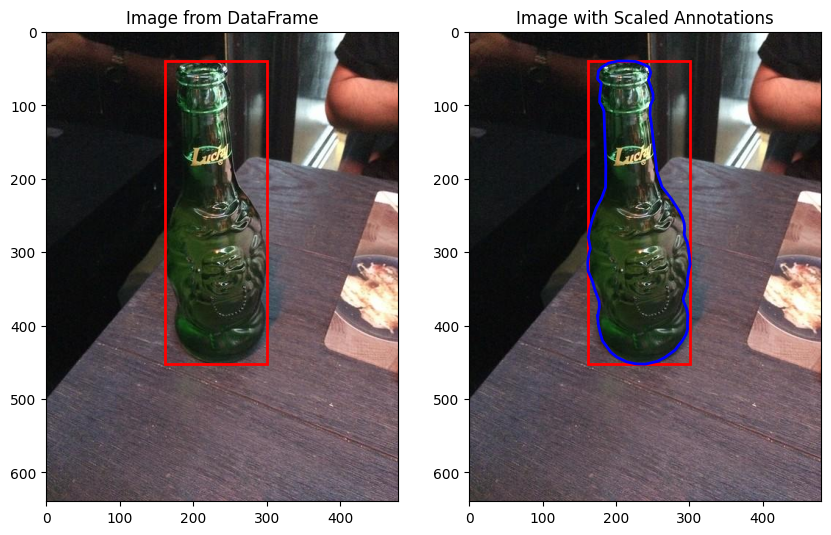

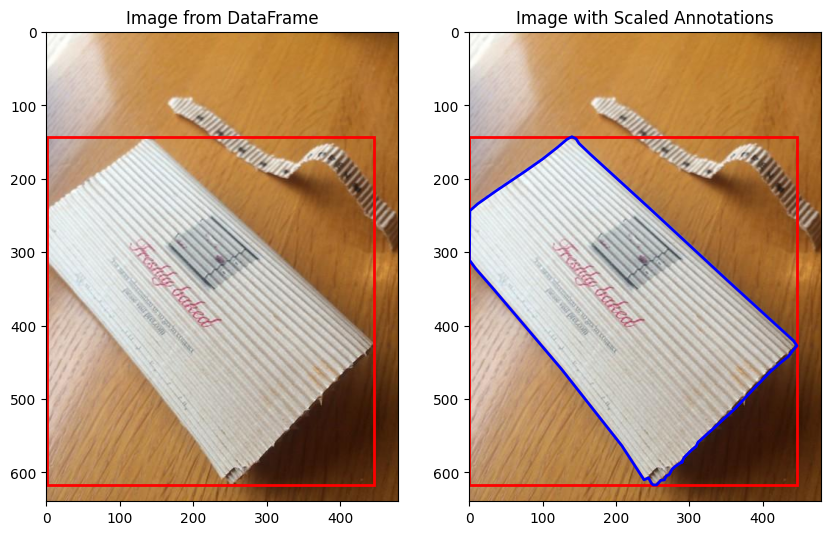

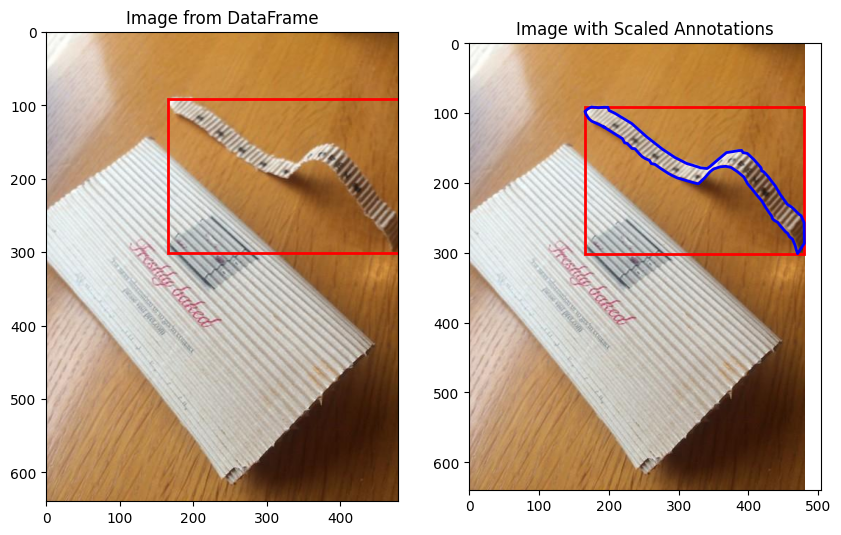

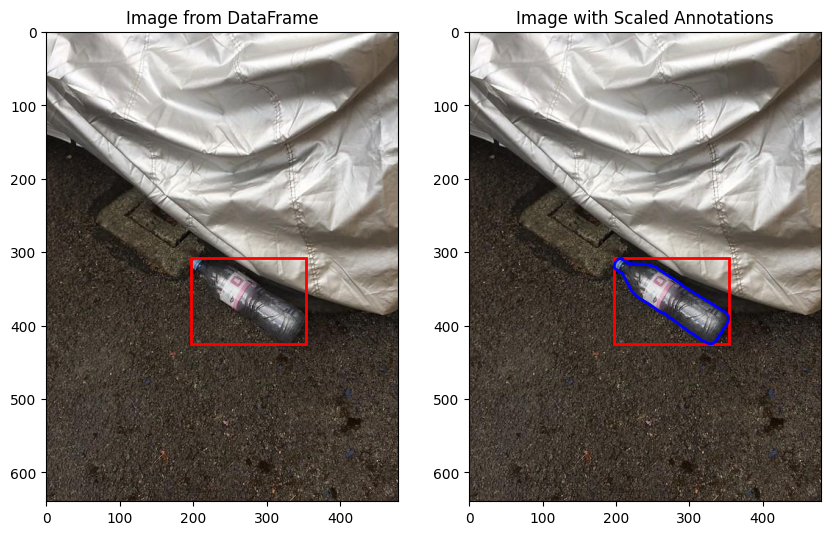

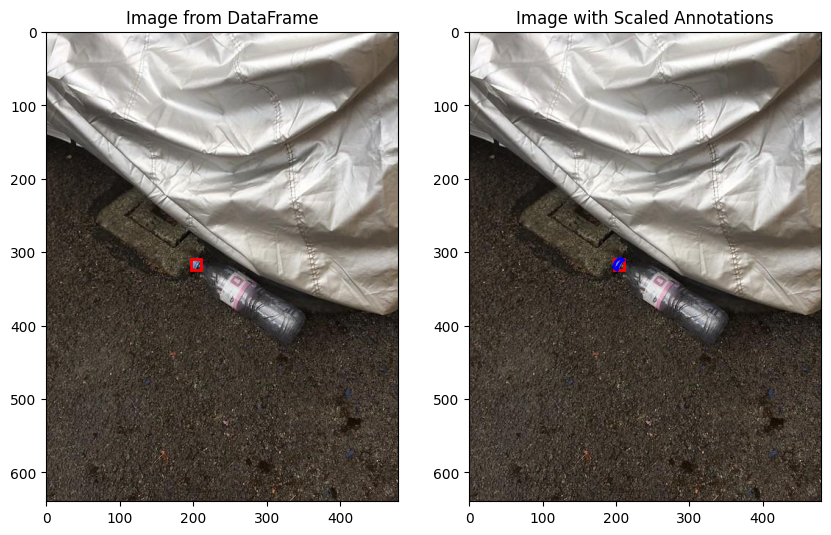

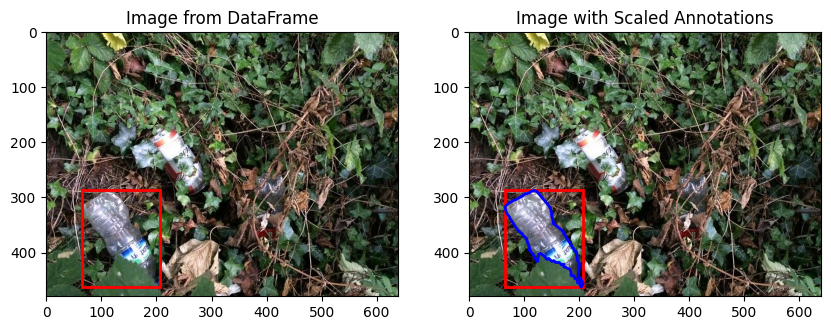

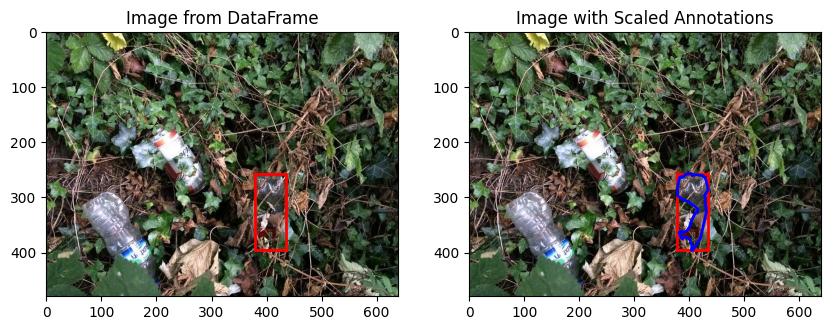

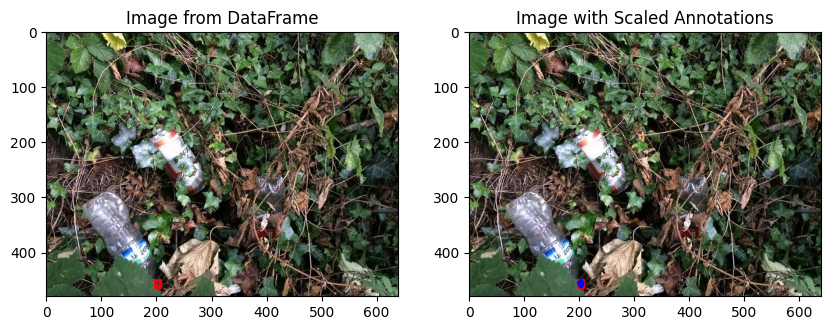

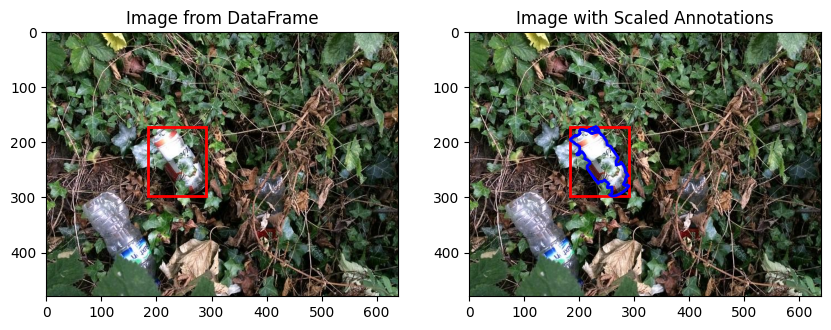

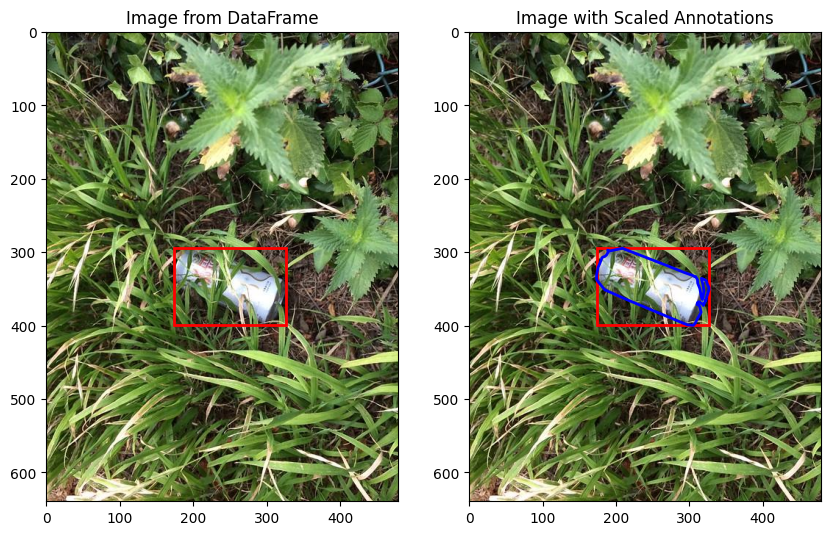

In [6]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Load the DataFrame
image_annotation_df = pd.read_csv('image_annotation_df.csv')

# Define a function to display images with bounding boxes and segmentation
def display_image_with_annotations(row, base_dir='/content/drive/MyDrive/downloaded_images_'):
    file_name = row['file_name']
    bbox = [row['bbox_x'], row['bbox_y'], row['bbox_width'], row['bbox_height']]
    segx = eval(row['segx'])  # Convert from string back to list
    segy = eval(row['segy'])  # Convert from string back to list

    # Load the image from local directory
    image_path = os.path.join(base_dir, file_name)
    img = Image.open(image_path)
    new_size = img.size

    # Display the original image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Image from DataFrame")

    # Draw bounding box
    plt.subplot(1, 2, 1)
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

    # Draw segmentation
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.title("Image with Scaled Annotations")

    # Draw the scaled bounding box
    rect_scaled = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect_scaled)

    # Draw segmentation points
    plt.plot(segx, segy, 'b-', linewidth=2)

    plt.show()

# Test out the first few images in the DataFrame
for idx, row in image_annotation_df.head(10).iterrows():
    display_image_with_annotations(row)

In [9]:
import os

def update_image_paths(df, base_dir='downloaded_images_'):
    # Iterate over each row and update file paths
    for idx, row in df.iterrows():
        for root, dirs, files in os.walk(base_dir):
            if row['file_name'] in files:
                # Update file name with the correct subdirectory path
                df.at[idx, 'file_name'] = os.path.join(root, row['file_name'])
    return df

# Update the DataFrame
df = update_image_paths(df)

Adding files to drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import os
# folder_name = 'downloaded_images_'
# path = '/content/drive/MyDrive/' + folder_name
# os.makedirs(path, exist_ok=True)

<h1><b>Model

In [10]:
import torch
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import os
import numpy as np

In [15]:
import torch
import numpy as np
from PIL import ImageDraw, Image
from torchvision.transforms import ToTensor

class TrashDataset(Dataset):
    def __init__(self, df, base_dir, transforms=None):
        self.df = df
        self.base_dir = base_dir
        self.transforms = transforms

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.base_dir, row['file_name'])
        img = Image.open(img_path).convert("RGB")

        # Get the image size BEFORE transforming the image to a tensor
        original_size = img.size  # Get (width, height) from PIL Image

        # Convert image to tensor
        if self.transforms:
            img = self.transforms(img)
        else:
            img = ToTensor()(img)

        # Fix the bounding box format from [xmin, ymin, width, height] to [xmin, ymin, xmax, ymax]
        xmin = row['bbox_x']
        ymin = row['bbox_y']
        width = row['bbox_width']
        height = row['bbox_height']
        xmax = xmin + width
        ymax = ymin + height

        # Ensure positive width and height
        if width <= 0 or height <= 0:
            raise ValueError(f"Invalid bounding box dimensions: {width}x{height} for image {img_path}")

        bbox = torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32)
        labels = torch.ones((1,), dtype=torch.int64)  # Assuming all objects are trash

        # Get segmentation points and convert them to binary mask
        segx = eval(row['segx'])  # Assuming segx and segy are stored as stringified lists
        segy = eval(row['segy'])

        # Use the original size from the PIL Image to create the mask
        mask = self.polygon_to_mask(original_size, segx, segy)

        # Convert mask to tensor
        mask = torch.tensor(mask, dtype=torch.uint8).unsqueeze(0)

        target = {
            'boxes': bbox,
            'labels': labels,
            'masks': mask,
            'image_id': torch.tensor([row['image_id']], dtype=torch.int64),
            'area': torch.tensor([width * height], dtype=torch.float32),
            'iscrowd': torch.zeros((1,), dtype=torch.int64)
        }

        return img, target

    def __len__(self):
        return len(self.df)

    # Convert polygon to binary mask
    def polygon_to_mask(self, image_size, segx, segy):
        width, height = image_size  # Correctly extract width and height from PIL Image size
        mask = Image.new('L', (width, height), 0)  # Create a blank image
        polygon = [(x, y) for x, y in zip(segx, segy)]  # Create polygon points
        ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)  # Draw the polygon on the mask
        return np.array(mask)

In [16]:
from torch.utils.data import DataLoader
from torchvision import transforms  # Import torchvision.transforms

def collate_fn(batch):
    return tuple(zip(*batch))
# Define the DataLoader with the updated dataset class
train_loader = DataLoader(
    TrashDataset(df, '/content/drive/MyDrive/downloaded_images_', transforms=transforms.ToTensor()),
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    TrashDataset(df, '/content/drive/MyDrive/downloaded_images_', transforms=transforms.ToTensor()),
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [17]:
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# Load a pre-trained ResNet-101 backbone with FPN
backbone = torchvision.models.detection.backbone_utils.resnet_fpn_backbone('resnet101', pretrained=True)

# Initialize Mask R-CNN
model = MaskRCNN(backbone, num_classes=2)  # Assuming 1 class (trash) + background

# Modify the head to fit your number of classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=2)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, 256, num_classes=2)

In [ ]:
import torch.optim as optim

# Set up the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 3
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0

    for images, targets in train_loader:
        images = list(image for image in images)
        targets = [{k: v for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)  # Forward pass
        losses = sum(loss for loss in loss_dict.values())  # Sum the losses
        losses.backward()  # Backward pass
        optimizer.step()

        running_loss += losses.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

In [ ]:
# import torch
# from torch.utils.data import Dataset
# import json
# import os
# import cv2
# import numpy as np
# class CustomDataset(Dataset):
#     def __init__(self, annotation_file, image_dir, train_dataset, transform=None):
#         with open(annotation_file) as f:
#             self.coco = json.load(f)
#         self.image_dir = image_dir
#         self.transform = transform
#         self.images = self.coco['images']
#         self.annotations = self.coco['annotations']

#     def __getitem__(self, idx):
#         img_info = self.images[idx]
#         img_path = os.path.join(self.image_dir, img_info['file_name'])

#         # Load the image
#         image = cv2.imread(img_path)

#         # If the image is missing or empty, return None
#         if image is None:
#             print(f"Error: Image not found or empty at path: {img_path}")
#             return None, None

#         # Convert BGR to RGB
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         # Get annotations for the image
#         img_id = img_info['id']
#         boxes = []
#         masks = []
#         for annotation in self.annotations:
#             if annotation['image_id'] == img_id:
#                 boxes.append(annotation['bbox'])
#                 masks.append(self._get_mask(annotation))

#         # Convert data to tensors
#         boxes = torch.as_tensor(boxes, dtype=torch.float32)
#         masks = torch.as_tensor(masks, dtype=torch.uint8)

#         target = {'boxes': boxes, 'masks': masks}

#         if self.transform:
#             image = self.transform(image)

#         return image, target

#     def __len__(self):
#         return len(self.images)

#     def _get_mask(self, annotation):
#         height, width = self.coco['images'][annotation['image_id']]['height'], self.coco['images'][annotation['image_id']]['width']
#         mask = np.zeros((height, width), dtype=np.uint8)
#         if isinstance(annotation['segmentation'], list):
#             for polygon in annotation['segmentation']:
#                 pts = np.array(polygon).reshape((-1, 2))
#                 cv2.fillPoly(mask, [pts], 1)
#         return mask

In [ ]:
# from sklearn.model_selection import train_test_split

# # Load dataset annotations
# with open('annotations.json') as f:
#     annotations = json.load(f)

# # Split images into training and validation sets (80-20 split)
# train_images, val_images = train_test_split(annotations['images'], test_size=0.2, random_state=42)

# # Now we need to create two dataset instances: one for training and one for validation
# # train_dataset = CustomDataset('annotations.json', 'download_images_')
# # val_dataset = CustomDataset('annotations.json', 'download_images_')

In [ ]:
# def custom_collate_fn(batch):
#     # Filter out invalid data (None, None)
#     batch = list(filter(lambda x: x[0] is not None, batch))

#     if len(batch) == 0:
#         return None  # If no valid data, return None

#     images, targets = zip(*batch)

#     return images, targets

In [ ]:
# from torch.utils.data import DataLoader
# train_dataset = CustomDataset('annotations.json', 'download_images_')

# # Create DataLoader with custom collate_fn
# train_loader = DataLoader(
#     train_dataset,
#     batch_size=4,
#     shuffle=True,
#     num_workers=4,
#     collate_fn=custom_collate_fn
# )


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# import torch.optim as optim
# from torch.utils.data import DataLoader

# # Load dataset
# train_dataset = CustomDataset('annotations.json', 'download_images_')
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

# # Instantiate model and optimizer
# model = MaskRCNN(ResNet101Model())
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Define loss functions
# bbox_loss_fn = nn.SmoothL1Loss()
# mask_loss_fn = nn.BCEWithLogitsLoss()

# # Training loop
# for epoch in range(10):  # Train for 10 epochs or more
#     model.train()
#     running_loss = 0.0
#     try:
#         for batch in train_loader:
#             # Skip empty or invalid batches
#             if batch is None:
#                 continue

#             images, targets = batch
#             optimizer.zero_grad()

#             # Forward pass
#             bboxes_pred, masks_pred = model(images)

#             # Compute losses
#             bbox_loss = bbox_loss_fn(bboxes_pred, targets['boxes'])
#             mask_loss = mask_loss_fn(masks_pred, targets['masks'])

#             # Total loss
#             total_loss = bbox_loss + mask_loss

#             # Backward pass
#             total_loss.backward()
#             optimizer.step()

#             running_loss += total_loss.item()
#     except Exception:
#         pass

#     print(f"Epoch [{epoch + 1}], Loss: {running_loss / len(train_loader)}")

In [ ]:
# # Switch model to evaluation mode
# model.eval()

# # Disable gradient computation for inference
# with torch.no_grad():
#     for batch in val_loader:
#         if batch is None:
#             continue

#         images, targets = batch

#         # Forward pass
#         bboxes_pred, masks_pred = model(images)

#         # Compute evaluation metrics, such as IoU, precision, recall, etc.
#         # Example: Using Intersection over Union (IoU) for bounding box evaluation
#         iou = compute_iou(bboxes_pred, targets['boxes'])
#         print(f"IoU for this batch: {iou}")

#**Trials**

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, annotations, image_dir, transforms=None):
        """
        annotations: DataFrame containing the annotations.
        image_dir: Directory where the images are stored.
        transforms: Any data augmentation or preprocessing transforms to apply.
        """
        self.annotations = annotations
        self.image_dir = image_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Get the annotation row
        annotation = self.annotations.iloc[idx]

        # Load the image
        img_path = os.path.join(self.image_dir, annotation['file_name'])
        image = Image.open(img_path).convert("RGB")

        # Get the target (annotations)
        target = {}
        target['boxes'] = torch.tensor([[annotation['bbox_x'], annotation['bbox_y'],
                                         annotation['bbox_x'] + annotation['bbox_width'],
                                         annotation['bbox_y'] + annotation['bbox_height']]], dtype=torch.float32)
        target['labels'] = torch.tensor([annotation['category_id']], dtype=torch.int64)
        target['image_id'] = torch.tensor([annotation['image_id']])
        target['area'] = torch.tensor([annotation['area']], dtype=torch.float32)
        target['iscrowd'] = torch.tensor([annotation['iscrowd']], dtype=torch.int64)

        # Apply any transforms to the image
        if self.transforms:
            image = self.transforms(image)

        return image, target


In [ ]:
from torchvision import transforms

# Define any data augmentation or preprocessing transforms (e.g., resizing, normalization)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
])

# Directory where images are stored
image_dir = 'downloaded_images'

# Create datasets
train_dataset = CustomDataset(train_annotations, image_dir, transforms=transform)
val_dataset = CustomDataset(val_annotations, image_dir, transforms=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
train_dataset[0]

(tensor([[[0.1137, 0.1059, 0.0980,  ..., 0.0706, 0.0706, 0.0706],
          [0.1137, 0.1059, 0.1020,  ..., 0.0863, 0.0863, 0.0863],
          [0.1137, 0.1098, 0.1059,  ..., 0.0941, 0.0980, 0.0980],
          ...,
          [0.2706, 0.2549, 0.2510,  ..., 0.7961, 0.7451, 0.7020],
          [0.2863, 0.2941, 0.3216,  ..., 0.7765, 0.7804, 0.6980],
          [0.5725, 0.5569, 0.5451,  ..., 0.7333, 0.7765, 0.6667]],
 
         [[0.0784, 0.0706, 0.0627,  ..., 0.0667, 0.0667, 0.0667],
          [0.0784, 0.0706, 0.0667,  ..., 0.0824, 0.0824, 0.0824],
          [0.0784, 0.0745, 0.0706,  ..., 0.0902, 0.0941, 0.0941],
          ...,
          [0.2549, 0.2392, 0.2353,  ..., 0.6941, 0.6431, 0.6000],
          [0.2706, 0.2784, 0.3059,  ..., 0.6745, 0.6784, 0.5961],
          [0.5569, 0.5412, 0.5294,  ..., 0.6314, 0.6745, 0.5647]],
 
         [[0.0902, 0.0824, 0.0745,  ..., 0.0902, 0.0902, 0.0902],
          [0.0902, 0.0824, 0.0784,  ..., 0.1059, 0.1059, 0.1059],
          [0.0902, 0.0863, 0.0824,  ...,

In [ ]:
import torch
import torch.optim as optim

# Set the device (GPU if available)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Set the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader)}")

    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_targets in val_loader:
            val_images = list(image.to(device) for image in val_images)
            val_targets = [{k: v.to(device) for k, v in t.items()} for t in val_targets]

            val_loss_dict = model(val_images, val_targets)
            val_losses = sum(loss for loss in val_loss_dict.values())
            val_loss += val_losses.item()

    print(f"Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader)}")


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 317, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 174, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 174, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 142, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 213, in collate_tensor_fn
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
RuntimeError: Trying to resize storage that is not resizable
